# Getting started with `pyrenew`

This notebook illustrates two features of `pyrenew`: (a) the set of included `RandomProcess`es, and (b) model composition.

## Hospitalizations model

`pyrenew` has four main components:

- Utilitiy and math functions
- The `processes` sub-module
- The `observations` sub-module
- The `models` sub-module

Both `processes` and `observations` contain classes that inherit from the meta class `RandomProcess`. The classes under `models` inherit from the meta class `Model`.

```{mermaid}
flowchart TB

    subgraph randprocmod["Processes module"]
        direction TB
        simprw["SimpleRandomWalkProcess"]
        rtrw["RtRandomWalkProcess"]        
    end

    subgraph obsmod["Observations module"]
        direction TB
        pois["PoissonObservation"]
        hosp_obs["HospitalizationsObservation"]
    end

    rp(("RandomProcess")) --> |Inherited by| simprw
    rp -->|Inherited by| rtrw
    rp -->|Inherited by| pois
    rp -->|Inherited by| hosp_obs


    model(("Model")) -->|Inherited by| basic["BasicRenewalModel"]

    simprw -->|Composes| rtrw
    rtrw -->|Composes| basic
    basic -->|Inherited by| hosp["HospitalizationsModel"]


    pois -->|Composes| hosp
    hosp_obs -->|Composes| hosp

    %% Metaclasses
    classDef Metaclass color:black,fill:white
    class rp,model Metaclass

    %% Random process
    classDef Randproc fill:purple,color:white
    class rtrw,simprw Randproc

    %% Models
    classDef Models fill:teal,color:white
    class basic,hosp Models
```

In [1]:
import jax.numpy as jnp
import numpy as np
import numpyro as npro
from pyrenew.models import BasicRenewalModel
from pyrenew.observations import (
    InfectionsObservation,
    PoissonObservation
)

# Creating the model and simulating data
infections_obs = InfectionsObservation(
    jnp.array([0.25, 0.25, 0.25, 0.25]),
    inf_observation_model=PoissonObservation()
    )

model1 = BasicRenewalModel(infections_obs=infections_obs)

np.random.seed(223)
with npro.handlers.seed(rng_seed=np.random.randint(1, 60)):
    sim_data = model1.model(data=dict(n_timepoints=30))

sim_data

/home/xrd4/.cache/pypoetry/virtualenvs/pyrenew-e8bt3r2y-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(Array([1.2022278, 1.2111099, 1.2325984, 1.2104921, 1.2023039, 1.1970979,
        1.2384264, 1.2423582, 1.245498 , 1.241344 , 1.2081108, 1.1938375,
        1.271196 , 1.3189521, 1.3054799, 1.3165426, 1.291952 , 1.3026639,
        1.2619467, 1.2852622, 1.3121517, 1.2888998, 1.2641873, 1.2580931,
        1.2545817, 1.3092988, 1.2488269, 1.2397509, 1.2071848, 1.2334517,
        1.21868  ], dtype=float32),
 Array([ 4,  3,  6,  5,  7,  7, 10, 11,  6,  9,  7, 13, 16, 19, 20, 27, 23,
        31, 28, 30, 43, 42, 55, 57, 44, 52, 64, 52, 77, 85, 94],      dtype=int32))

The `model()` method of the `BasicRenewalModel` returns a list composed of the `Rt` and `infections` sequences.

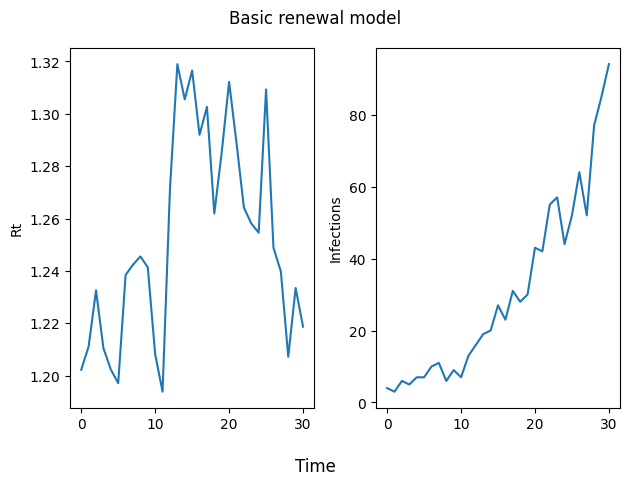

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

# Rt plot
axs[0].plot(range(0, 31), sim_data[0])
axs[0].set_ylabel('Rt')

# Infections plot
axs[1].plot(range(0, 31), sim_data[1])
axs[1].set_ylabel('Infections')

fig.suptitle('Basic renewal model')
fig.supxlabel('Time')
plt.tight_layout()
plt.show()

Let's see how the estimation would go

In [3]:
import jax

model1.set_observed_infections(sim_data[1])

model_data = {'n_timepoints': len(sim_data[1])-1}

model1.run(
    num_warmup=2000,
    num_samples=1000,
    data=model_data,
    rng_key=jax.random.PRNGKey(54)
    )

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1164.82it/s, 127 steps of size 3.31e-02. acc. prob=0.94]


Now, let's investigate the output

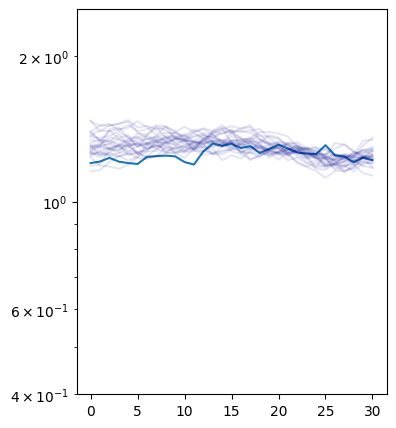

In [7]:
import polars as pl
samps = model1.spread_draws([('Rt', 'time')])

fig, ax = plt.subplots(figsize=[4, 5])

ax.plot(sim_data[0])
samp_ids = np.random.randint(size=25, low=0, high=999)
for samp_id in samp_ids:
    sub_samps = samps.filter(pl.col("draw") == samp_id).sort(pl.col('time'))
    ax.plot(sub_samps.select("time").to_numpy(), 
            sub_samps.select("Rt").to_numpy(), color="darkblue", alpha=0.1)
ax.set_ylim([0.4, 1/.4])
ax.set_yticks([0.5, 1, 2])
ax.set_yscale("log")